In [ ]:
!git clone https://github.com/arcprizeorg/model_baseline.git

In [ ]:
!git clone https://github.com/fchollet/ARC-AGI.git

In [30]:
import os
import json
def load_evaluation_tasks():
    base_path = 'ARC-AGI/data'
    folder_tasks = sorted(os.listdir(f"{base_path}/evaluation"))
    evaluation_tasks = {}

    for task in folder_tasks:
        with open(f"{base_path}/evaluation/{task}", "r") as f:
            task_data = json.load(f)
            id = task.split('.')[0]
            task_data['id'] = id
            evaluation_tasks[id] = task_data

    return evaluation_tasks

folder = 'open_ai_o3_high_20241220'
with open(f'model_baseline/results/{folder}/results.json', 'r') as f:
    results = json.load(f)['task_results'] # {'f0afb749': 1.0, ...}
with open(f'model_baseline/results/{folder}/attempts.json', 'r') as f:
    attempts = json.load(f) # {'f0afb749': 1.0, ...}
evaluation_tasks = load_evaluation_tasks()

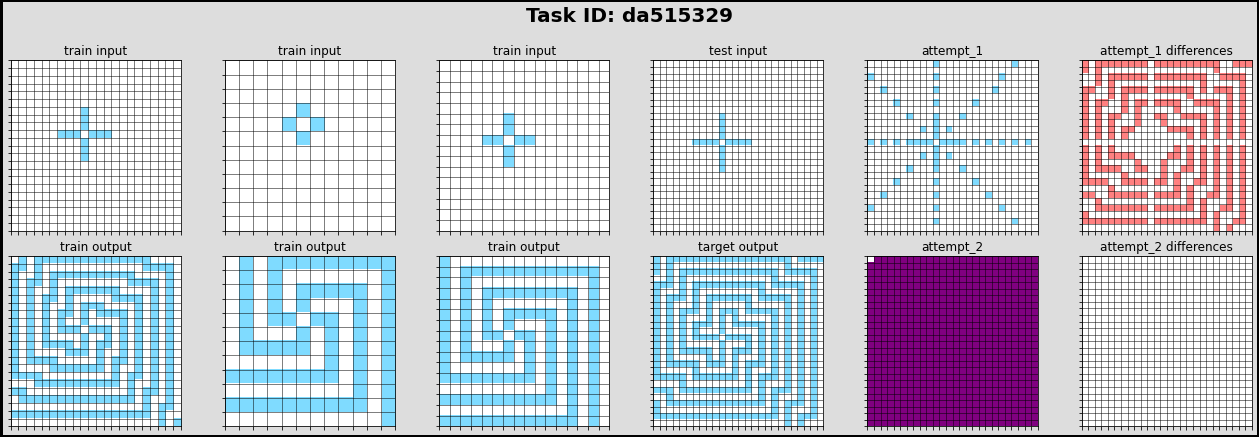

In [100]:
import matplotlib.pyplot as plt
from matplotlib import colors

cmap = colors.ListedColormap(
    ['#FFFFFF', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#800080'])
norm = colors.Normalize(vmin=0, vmax=10)


def plot_task(task, attempt=None, save_path=None):
    """Plots training examples and test pair with predicted output for an ARC task"""   
    num_train = len(task['train'])

    total_cols = num_train + 1 + (2 if attempt else 0)
    fig, axs = plt.subplots(2, total_cols, figsize=(3*total_cols, 3*2))
    plt.suptitle(f'Task ID: {task["id"]}', fontsize=20, fontweight='bold', y=1)
    
    for j in range(num_train):     
        plot_one(task['train'][j]['input'], axs[0, j], 'train input')
        plot_one(task['train'][j]['output'], axs[1, j], 'train output')        
    
    plot_one(task['test'][0]['input'], axs[0, num_train], 'test input')
    plot_one(task['test'][0]['output'], axs[1, num_train], 'target output')
    
    if attempt:
        target = np.array(task['test'][0]['output'])
        
        for idx, attempt_key in enumerate(['attempt_1', 'attempt_2']):
            try:
                attempt_array = np.array(pad_ragged_array(attempt[attempt_key]))
                max_height = max(attempt_array.shape[0], target.shape[0])
                max_width = max(attempt_array.shape[1], target.shape[1])

                padded_attempt = np.full((max_height, max_width), 10)
                padded_target = np.full((max_height, max_width), 10)
                
                padded_attempt[:attempt_array.shape[0], :attempt_array.shape[1]] = attempt_array
                padded_target[:target.shape[0], :target.shape[1]] = target
                
                plot_one(padded_attempt, axs[idx, -2], f'{attempt_key}')
                
                differences = (padded_attempt != padded_target)
                if differences.any():
                    axs[idx, -1].imshow(differences, 
                        cmap=colors.ListedColormap([(0,0,0,0), (1,0,0,0.5)]),
                        alpha=1.0)
                    axs[idx, -1].grid(True, which='both', color='black', linewidth=0.5)
                    axs[idx, -1].set_xticks([x-0.5 for x in range(1 + max_width)])
                    axs[idx, -1].set_yticks([x-0.5 for x in range(1 + max_height)])
                    axs[idx, -1].set_xticklabels([])
                    axs[idx, -1].set_yticklabels([])
                    axs[idx, -1].set_title(f'{attempt_key} differences')
                        
            except Exception as e:
                print(f"[{result_id}] Error processing {attempt_key}: {str(e)}")
                axs[idx, -2].set_title(f'{attempt_key} (error)')


    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
   
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()
    
def plot_one(matrix, ax, title):
    """Plots a single grid from the ARC task"""
    ax.imshow(matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='black', linewidth=0.5)
    
    ax.set_xticks([x-0.5 for x in range(1 + len(matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(matrix))])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title(title)

def pad_ragged_array(ragged_array, pad_value=10):
    """Pads a ragged array to make it rectangular using the pad_value"""
    max_width = max(len(row) for row in ragged_array)
    height = len(ragged_array)
    padded = []
    
    for row in ragged_array:
        padded_row = row + [pad_value] * (max_width - len(row))
        padded.append(padded_row)
    
    return padded

result_id = min(results, key = results.get)
# result_id = '52fd389e' # 'a3f84088'
attempt = attempts[result_id][0]
task = evaluation_tasks[result_id]
plot_task(task, attempt)

In [101]:
folder = 'o3-incorrect-analysis'
os.makedirs(folder, exist_ok=True)

for result_id in [r for r in results if results[r] == 0.0]:
    two_attempts = attempts[result_id][0]
    task = evaluation_tasks[result_id]
    try:
        plot_task(task, two_attempts, f'{folder}/{result_id}.png')
    except Exception as e:
        print(f'[{result_id}] error: {e}')
        continue